In [41]:
%matplotlib notebook
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, desc, and_
import pymysql
pymysql.install_as_MySQLdb()


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
dataM= session.query(Measurement).first()
dataM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10f0ed630>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

In [11]:
dataS= session.query(Station).first()
dataS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10f0fc240>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


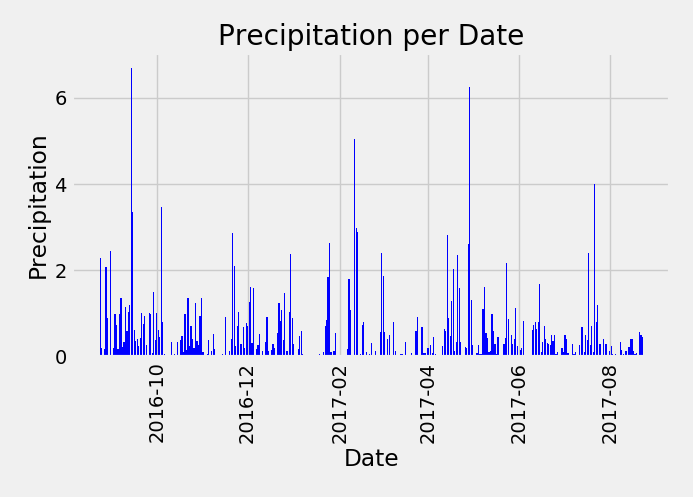

In [32]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
date = dt.datetime.strptime(last_date, "%Y-%m-%d")

date2=date - dt.timedelta(days = 365)
date3 = date2.strftime( "%Y-%m-%d")

prcp_dates = session.query(
    Measurement.date,
    Measurement.prcp
).filter(
     Measurement.date > date3).all()

df1=pd.DataFrame(
    prcp_dates, columns = ['date', 'precipitation']
)
df1=df1.set_index('date')
df1=df1.sort_values('date', ascending=True)
df1.index = pd.to_datetime(df1.index)

prcp_chart = plt.bar(df1.index, df1.precipitation, color='b', align="center" )
plt.title("Precipitation per Date")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation="vertical")
plt.tight_layout()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

count_prcp = session.query(
    func.count(Measurement.prcp)
).filter(
     Measurement.date > date3).all()

mean_prcp = session.query(
    func.avg(Measurement.prcp)
).filter(
     Measurement.date > date3).all()

min_prcp = session.query(
    func.min(Measurement.prcp)
).filter(
     Measurement.date > date3).all()

max_prcp = session.query(
    func.max(Measurement.prcp)
).filter(
     Measurement.date > date3).all()

summary=df1.describe()
summary      

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
station = session.query(
    func.count(distinct(Measurement.station))
).all()

station

[(9)]

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order. 

activity = session.query(
    Measurement.station,
    func.count(Measurement.tobs)
).group_by(
    Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()

activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:

station_1_activity = session.query(
    Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).group_by(
    Measurement.station
).order_by(desc(func.count(Measurement.tobs))).first()
station_1_activity

('USC00519281', 54.0, 85.0, 71.66378066378067)

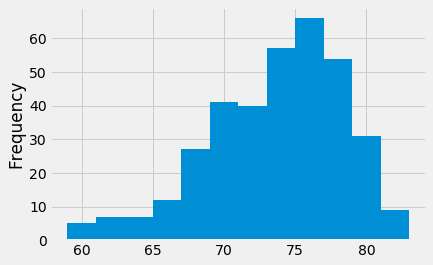

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results
last_date_s1 = session.query(
    Measurement.date 
).filter(
    Measurement.station == station_1_activity[0]
).order_by(Measurement.date.desc()).first().date

date_s1 = dt.datetime.strptime(last_date_s1, "%Y-%m-%d")

date2_s1=date_s1 - dt.timedelta(days = 365)
date3_s1 = date2_s1.strftime( "%Y-%m-%d")

temp = session.query(
    Measurement.tobs
).filter(
    and_(
        Measurement.station == station_1_activity[0],
        Measurement.date > date3_s1)).all()

df2=pd.DataFrame(
    temp, columns = ['temp']
)

temp_chart = plt.hist(df2.temp, bins=12)
plt.ylabel("Frequency")
plt.show(temp_chart)
 

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
start_date= ('2013-08-17')
end_date = ('2014-06-20')


calc_temp = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    and_(
    Measurement.date>=start_date,
    Measurement.date<=end_date)).all()

calc_temp

[(57.0, 86.0, 72.42495559502665)]

In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date= ('2013-12-17')
trip_end_date = ('2014-1-20')


trip_calc_temp = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    and_(
    Measurement.date>=trip_start_date,
    Measurement.date<=trip_end_date)).all()

trip_calc_temp

[(57.0, 85.0, 73.089407191448)]

TypeError: 'str' object is not callable

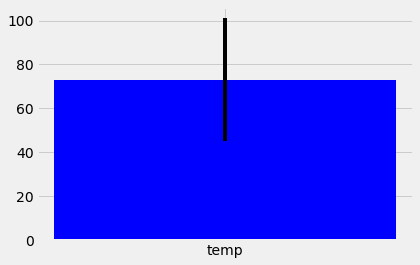

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df3 = pd.DataFrame(
    trip_calc_temp, columns = ['min_temp', 'max_temp', 'avg_temp']
)
df3.head()

prcp_chart = plt.bar('temp', df3.avg_temp, yerr=[[28.0]],color='b', align="center" )
plt.title('Trip Avg Temp')
plt.show()


In [40]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date= ('2013-12-17')
trip_end_date = ('2014-1-20')
prev_start_date=('2012-12-17')
prev_end_date=('2013-1-20')

prcp_summary = session.query(
    Measurement.prcp,
    Measurement.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation
).join(
    Station,
    Station.station == Measurement.station
).filter(
    and_(
    Measurement.date>=prev_start_date,
    Measurement.date<=prev_end_date)).order_by(Measurement.prcp.desc()).all()

prcp_summary


[(5.96,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (4.32,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (4.07,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (3.88,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (3.79,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (3.7,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (3.01,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (2.92,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (2.84,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (2.81,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (2.8,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331

## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
